In [6]:
import requests
import json
import pandas as pd
import random
import time
from datetime import datetime
from timeit import default_timer as timer
from requests_ip_rotator import ApiGateway, EXTRA_REGIONS, ALL_REGIONS
import os
from os import listdir
from os.path import exists, isfile, join
import re

## Functions

In [2]:
#Better readability for JSON output
def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent = 4)
    print(text)
    
def get_trades(tid_start, tid_end, currency):
    
    import time
    if tid_start >= tid_end: #make sure valid starting and ending values provided
        tid = 0
        tmp_list = [] #temp list to hold dfs from loop
        trades = pd.DataFrame() #final df of trades
        i = 0 #while-loop counter for sleep function
        path = '../temporary/trades_by_country/trades_' + str(currency) + '.csv'
        exists = os.path.exists(path)
        print(exists)
        
        if exists == True: #check if a file is already there, if so start where you left off
            df = pd.read_csv(path)
            tmp_list.append(df)
            tid = df['tid'].iloc[-1]
        else:
            tid = tid_start #initialize 'tid' to starting value
        
        gateway = ApiGateway("https://localbitcoins.com", regions = ["us-west-2"]) #Use ApiGateway from requests_ip_rotator to randomize IP used for requests to avoid rate limiting
        gateway.start() #open gateway, always shutdown as well

        session = requests.Session() #begin session
        session.mount("https://localbitcoins.com", gateway)

        
        try:
            while (tid >= tid_end):
                
                parameters = {
                    'max_tid': tid #passes current value of 'tid' as a parameter into the API request
                }

                url = 'https://localbitcoins.com/bitcoincharts/' + str(currency) + '/trades.json'

                t = session.get(url, params = parameters) #pull last 500 trades, starting with max_tid
                t.raise_for_status() #Returns HTTP error object if error occurs

                if len(t.json()) > 0: #if request returns nothing, avoids an error
                    df = pd.DataFrame(t.json()) #get JSON output into pd DataFrame
                    tmp_list.append(df.iloc[:-1]) #append to temp list, omits last row to avoid repeat obs

                    tid_last = df['tid'].iloc[-1] #gets the last tid of the previous dataset, new starting point for next loop
                    time.sleep(1 + (random.randint(0, 1000) / 1000))#sleep function to avoid API errors, this one moderates time between API requests
                    i += 1 #loop counter
                    
                    if tid != tid_last:
                        tid = tid_last
                    else:
                        raise ValueError('Got furthest back you could')
                    
                    if i%50 == 0:#multiples of 50
                        print(tid)
                        
                        

                    if i%500 == 0: #only for multiples of 500 (get API error around 800 without IP randomization)
                        # time.sleep(1200) #sleep for 20 minutes
                        print('congrats! you have made ' + str(i) + ' API requests, you insane person.')
                        # print(tid)
                else:
                    gateway.shutdown()
                    return None

        except ValueError as err:
            gateway.shutdown()
            print(err)
            trades = pd.concat(tmp_list, ignore_index=True) #concatinate all DFs in temp list into one dataframe
            trades['Currency'] = str(currency) #append the currency to a column
            return trades                
                
                
        except Exception as e:
            gateway.shutdown()
            print(t.status_code)
            print(e.response.text)
            print(tid)
            trades = pd.concat(tmp_list, ignore_index=True) #concatinate all DFs in temp list into one dataframe
            trades['Currency'] = str(currency) #append the currency to a column
            return trades
        
        except KeyboardInterrupt:
            gateway.shutdown()
            print(tid)
            trades = pd.concat(tmp_list, ignore_index=True) #concatinate all DFs in temp list into one dataframe
            trades['Currency'] = str(currency) #append the currency to a column
            return trades
        

            
        
        else:
            gateway.shutdown()
            trades = pd.concat(tmp_list, ignore_index=True) #concatinate all DFs in temp list into one dataframe
            trades['Currency'] = str(currency) #append the currency to a column
            return trades

    else:
        print('Please enter a value for tid_start that is greater than tid_end')

## Get list of currencies

In [3]:
altcoin = []
name = []

u = "https://localbitcoins.com/api/currencies/"
c = requests.get(u)
d = c.json()['data']['currencies'] #get to higher level of nesting
symbols = list(d.keys()) #get currency symbols

for currency in d:
    altcoin.append(d[str(currency)]['altcoin'])
    name.append(d[str(currency)]['name'])
    
currencies = pd.DataFrame(zip(symbols, name, altcoin), columns = ['symbol', 'currency', 'altcoin'])
currencies.to_csv('../temporary/currencies.csv', index=False)

In [32]:
symbols = list(currencies['symbol'][currencies['altcoin'] == False]) #Remove other cryptocurrencies
symbols.index('SGD')

126

In [33]:
symbols = list(currencies['symbol'][currencies['altcoin'] == False]) #Remove other cryptocurrencies
currencies_not_included = symbols[0:126]
symbols = [e for e in symbols if e not in currencies_not_included] #Remove symbols not to run
start_tid = 56510558
end_tid = 6000000 #6000000 corresponds to Feb 2017



for currency in symbols:
    
    start_tid = 56510558
    end_tid = 6000000 #6000000 corresponds to Feb 2017
    print(currency)
    start = timer()

    df = get_trades(start_tid, end_tid, currency)
    path = '../temporary/trades_by_country/trades_' + str(currency) + '.csv'
    end = timer()
    time = end - start
    print(time)
    
    if df is not None:
        df.to_csv(path, index = False)

SGD
True
Starting API gateway in 1 regions.
Using 1 endpoints with name 'https://localbitcoins.com - IP Rotate API' (1 new).
12420614
Deleting gateway for site 'https://localbitcoins.com'.
Deleted 1 endpoints with for site 'https://localbitcoins.com'.
133.75777039999957
SHP
False
Starting API gateway in 1 regions.
Using 1 endpoints with name 'https://localbitcoins.com - IP Rotate API' (1 new).
Deleting gateway for site 'https://localbitcoins.com'.
Deleted 1 endpoints with for site 'https://localbitcoins.com'.
5.266751999995904
SLL
False
Starting API gateway in 1 regions.
Using 1 endpoints with name 'https://localbitcoins.com - IP Rotate API' (1 new).
Deleting gateway for site 'https://localbitcoins.com'.
Deleted 1 endpoints with for site 'https://localbitcoins.com'.
Got furthest back you could
7.17261020001024
SOS
False
Starting API gateway in 1 regions.
Using 1 endpoints with name 'https://localbitcoins.com - IP Rotate API' (1 new).
Deleting gateway for site 'https://localbitcoins.com

In [52]:
datetime.fromtimestamp(1633522441)

datetime.datetime(2021, 10, 6, 6, 14, 1)

In [3]:
#See most recent trades
t = requests.get('https://localbitcoins.com/bitcoincharts/BTN/trades.json')
jprint(t.json())

[]


# Paxful

In [40]:
def get_pax_trades(tid_start, tid_end):
    if tid_start <= tid_end:
        i=0 #loop counter
        file_counter = 0
        tid = 0
        tmp_list = []
        trades = pd.DataFrame()
        # exists = os.path.exists(path)
        # print("True or False? The file exists: " + str(exists))
        
        # if exists == True: # check if file is already there
        #     df_tmp = pd.read_csv(path)
        #     tmp_list.append(df_tmp)
        #     tid = df_tmp['id'].iloc[-1]
        # else:
        #     tid = tid_start
        
        try:
            num = []
            mypath = '../temporary/trades_paxful/'
            files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
            for file in files:
                n = re.findall('\d+', file)
                num.append(int(n[0]))
            file_counter = max(num)
            print(file_counter)
            df_tmp = pd.read_csv(mypath + 'trades_paxful_' + str(file_counter) + '.csv')
            tid = df_tmp['id'].iloc[-1]
            print(tid)
        except:
            tid = tid_start
            print(tid)
            

            
        
        while (tid <= tid_end):
            try:
                time.sleep(2/1000 + (random.randint(0, 100) / 1000))
                url = 'https://paxful.com/data/trades?since=' + str(tid)
                t = requests.get(url)
                t.raise_for_status()
                
                df_tmp = pd.DataFrame(t.json())
                tmp_list.append(df_tmp)
                
                tid_last = df_tmp['id'].iloc[-1]
                tid = tid_last
                i += 1
                
                if i%100 == 0: #multiples of 20
                    print(tid)
                
                if i%500 == 0:
                    print('Congrats! you have made ' + str(i) + ' API requests, you insane person.')
                    
            except Exception as e:
                print("An API error occurred!")
                if len(tmp_list) != 0:
                    trades = pd.concat(tmp_list, ignore_index = True)
                file_counter += 1
                path = "../temporary/trades_paxful/trades_paxful_" + str(file_counter) + ".csv"
                time.sleep(60)



                try:                    
                    print(t.status_code)
                    print(e.response.text)
                    print(tid)
                    if len(tmp_lis) != 0:
                        trades.to_csv(path, index = False)
                    print("saved to csv")
                    tmp_list = []                    

                    # return trades
                except:
                    print(tid)
                    if len(tmp_list) != 0:
                        trades.to_csv(path, index = False)
                    print("saved to csv")
                    tmp_list = []
                    # return trades

            except KeyboardInterrupt:
                print(tid)
                trades = pd.concat(tmp_list, ignore_index = True)
                file_counter += 1
                path = "../temporary/trades_paxful/trades_paxful_" + str(file_counter) + ".csv"
                trades.to_csv(path, index = False)
                print("saved to csv, breaking loop")
                return trades

        print("Made it out of while loop")
        trades = pd.concat(tmp_list, ignore_index = True)
        file_counter += 1
        path = "../temporary/trades_paxful/trades_paxful_" + str(file_counter) + ".csv"
        trades.to_csv(path, index = False)
        return trades
    else:
        print("Please provide a value of tid_start that is greater than tid_end.")

230
62181864
62205992
62228380
62251384
62273842
62298157
Congrats! you have made 500 API requests, you insane person.
62322107
62348135
62371597
62393756
62416495
Congrats! you have made 1000 API requests, you insane person.
62440051
62462711
62485770
62508179
62530944
Congrats! you have made 1500 API requests, you insane person.
62554911
62576906
62598986
62621042
62644874
Congrats! you have made 2000 API requests, you insane person.
62667553
62690645
62714129
62736202
62760457
Congrats! you have made 2500 API requests, you insane person.
62783960
62808696
62834077
62857330
62882192
Congrats! you have made 3000 API requests, you insane person.
62906446
62929767
62952589
62975301
62998291
Congrats! you have made 3500 API requests, you insane person.
63022162
63047119
63071771
63099403
63125877
Congrats! you have made 4000 API requests, you insane person.
63152035
63177618
63202892
63226048
63248347
Congrats! you have made 4500 API requests, you insane person.
63272734
63298966
6332777
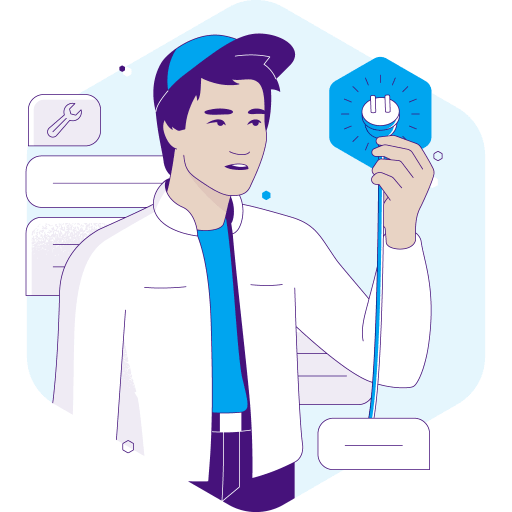
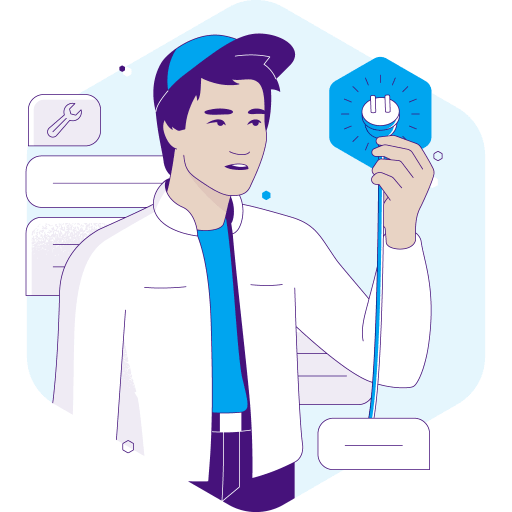
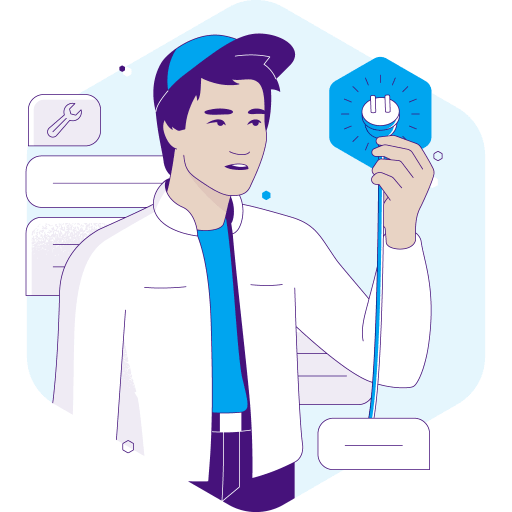

In [ ]:
#200223917 corresponds to the date I got localbtc to
get_pax_trades(4544608, 200223917)
# path = "../temporary/trades_paxful.csv"
# pax_trades.to_csv(path, index=False)


In [58]:
from datetime import datetime
print(datetime.fromtimestamp(1527196236))


2018-05-24 15:10:36


In [43]:

# print(datetime.fromtimestamp(1490047561))
import time
import datetime
string = '29/09/2022'
element = datetime.datetime.strptime(string,"%d/%m/%Y")
print(datetime.datetime.timestamp(element))

1664431200.0


In [20]:
from os import listdir
from os.path import isfile, join
mypath = '../temporary/trades_paxful/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for file in onlyfiles:
    num = re.findall('\d+', file)

type(num)

<class 'list'>


list

In [22]:
# tid_start = 5
# try:
num = []
mypath = '../temporary/trades_paxful/'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for file in files:
    n = re.findall('\d+', file)
    num.append(str(n[0]))
file_counter = max(num)
df_tmp = pd.read_csv(mypath + 'trades_paxful_' + str(file_counter) + '.csv')
tid = df_tmp['id'].iloc[-1]
print(tid)

# except:
#     tid = tid_start
#     print(tid)

4548720


In [4]:

# test = requests.get("https://paxful.com/data/trades?since=200104176")
test = requests.get("https://paxful.com/data/trades?sincetype=date&since=1664431200")
jprint(test.json())

[
    {
        "advertiser_cc": "IE",
        "amount": "0.00058518",
        "crypto_code": "BTC",
        "crypto_rate_usd": "19431.39",
        "currency": "NGN",
        "date": "1664431202",
        "duration": 251,
        "id": 200223917,
        "payment_method": "International Wire Transfer (SWIFT)",
        "payment_method_group": "Bank transfers",
        "price": "8230.00",
        "type": "sell",
        "user_cc": "NG"
    },
    {
        "advertiser_cc": "NG",
        "amount": "0.00244492",
        "crypto_code": "BTC",
        "crypto_rate_usd": "19455.38",
        "currency": "NGN",
        "date": "1664431202",
        "duration": 8844,
        "id": 200216991,
        "payment_method": "Bank Transfer",
        "payment_method_group": "Bank transfers",
        "price": "34788.59",
        "type": "sell",
        "user_cc": "NG"
    },
    {
        "advertiser_cc": "KE",
        "amount": "0.00078108",
        "crypto_code": "BTC",
        "crypto_rate_usd": "19431